In [3]:
import torch
from data.sampleable import MNISTSampler, GaussianConditionalProbabilityPath
from data.alpha_beta import LinearAlpha, LinearBeta
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def train_data(device):
        
    num_rows = 3
    num_cols = 3
    num_timesteps = 5

    # Initialize our sampler
    sampler = MNISTSampler().to(device)

    # Initialize probability path
    path = GaussianConditionalProbabilityPath(
        p_data = MNISTSampler(),
        p_simple_shape = [1, 32, 32],
        alpha = LinearAlpha(),
        beta = LinearBeta()
    ).to(device)

    # Sample 
    num_samples = num_rows * num_cols
    z, _ = path.p_data.sample(num_samples)
    z = z.view(-1, 1, 32, 32)

    # Setup plot
    fig, axes = plt.subplots(1, num_timesteps, figsize=(6 * num_cols * num_timesteps, 6 * num_rows))

    # Sample from conditional probability paths and graph
    ts = torch.linspace(0, 1, num_timesteps).to(device)
    for tidx, t in enumerate(ts):
        tt = t.view(1,1,1,1).expand(num_samples, 1, 1, 1) # (num_samples, 1, 1, 1)
        xt = path.sample_conditional_path(z, tt) # (num_samples, 1, 32, 32)
        grid = make_grid(xt, nrow=num_cols, normalize=True, value_range=(-1,1))
        axes[tidx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
        axes[tidx].axis("off")
    plt.show()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
from model.mnist_unet import MNISTUNet
from train.trainer import CFGTrainer
from data.sampleable import GaussianConditionalProbabilityPath

path = GaussianConditionalProbabilityPath(
    p_data = MNISTSampler(),
    p_simple_shape = [1, 32, 32],
    alpha = LinearAlpha(),
    beta = LinearBeta()
).to(device)

# Initialize model
unet = MNISTUNet(
    channels = [32, 64, 128],
    num_residual_layers = 2,
    t_embed_dim = 40,
    y_embed_dim = 40,
)

# Initialize trainer
trainer = CFGTrainer(path = path, model = unet, eta=0.1)

# Train!
trainer.train(num_epochs = 500, device=device, lr=1e-3, batch_size=250)

NameError: name 'LinearAlpha' is not defined

100%|██████████| 49/49 [00:00<00:00, 57.90it/s]


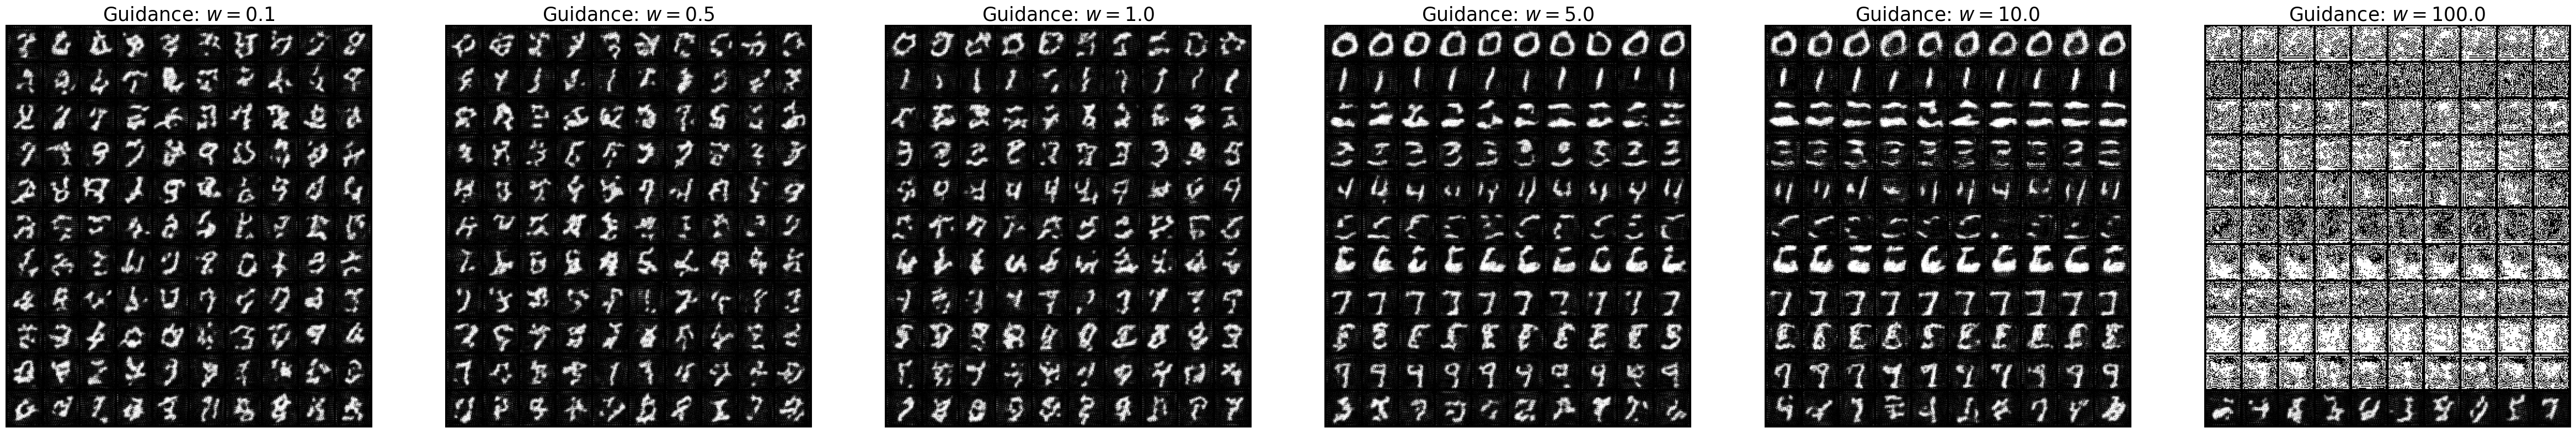

In [ ]:
from data.simulator import CFGVectorFieldODE, EulerSimulator

# Play with these!
samples_per_class = 10
num_timesteps = 50
guidance_scales = [0.1, 0.5, 1.0, 5.0, 10.0, 100.0]

# Graph
fig, axes = plt.subplots(1, len(guidance_scales), figsize=(10 * len(guidance_scales), 10))

for idx, w in enumerate(guidance_scales):
    # Setup ode and simulator
    ode = CFGVectorFieldODE(unet, guidance_scale=w)
    simulator = EulerSimulator(ode)

    # Sample initial conditions
    y = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=torch.int64).repeat_interleave(samples_per_class).to(device)
    num_samples = y.shape[0]
    x0, _ = path.p_simple.sample(num_samples) # (num_samples, 1, 32, 32)

    # Simulate
    ts = torch.linspace(0,1,num_timesteps).view(1, -1, 1, 1, 1).expand(num_samples, -1, 1, 1, 1).to(device)
    x1 = simulator.simulate(x0, ts, y=y)

    # Plot
    grid = make_grid(x1, nrow=samples_per_class, normalize=True, value_range=(-1,1))
    axes[idx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
    axes[idx].axis("off")
    axes[idx].set_title(f"Guidance: $w={w:.1f}$", fontsize=25)
plt.show()

In [ ]:
import torch

class ConstantC():
    def __call__(self, gamma):
        return torch.ones_like(gamma)

class LinearC():
    def __call__(self, gamma):
        return 1-gamma

class TruncatedDecayC():
    def __init__(self, alpha: float):
        self.alpha = alpha

    def __call__(self, gamma : torch.Tensor):
    
        mask = gamma <= self.alpha
        mask.to(gamma)
        
        c = (1- gamma) / (1 - self.alpha)
        c[mask] = 1.0
        
        return c


In [2]:
from model.mnist_unet import MNISTUNet
from train.trainer import EqMTrainer
from data.sampleable import GaussianEqM, MNISTSampler
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

path = GaussianEqM(
    p_data = MNISTSampler(),
    p_simple_shape = [1, 32, 32],
    grad_magnitude_func = TruncatedDecayC(alpha=0.8)
).to(device)

# Initialize model
unet = MNISTUNet(
    channels = [32, 64, 128],
    num_residual_layers = 3,
    t_embed_dim = 40,
    y_embed_dim = 40,
)

# Initialize trainer
trainer = EqMTrainer(data_sampler = path, model = unet, device=device)

# Train!
losses = trainer.train(num_epochs = 1000, device=device, lr=1e-3, batch_size=250)

Training model with size: 6.718 MiB


Epoch 999, loss: 2.172: : 1000it [01:34, 10.55it/s]


Text(0.5, 1.0, 'Training Loss')

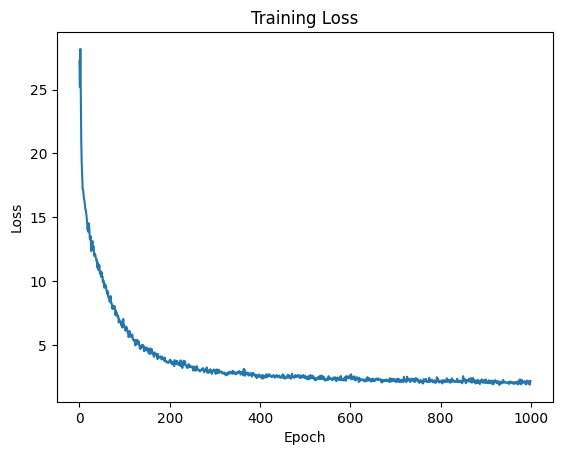

In [3]:
# plot the losses
from matplotlib import pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

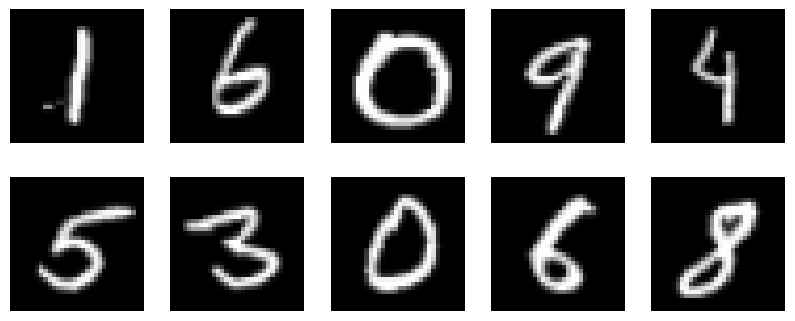

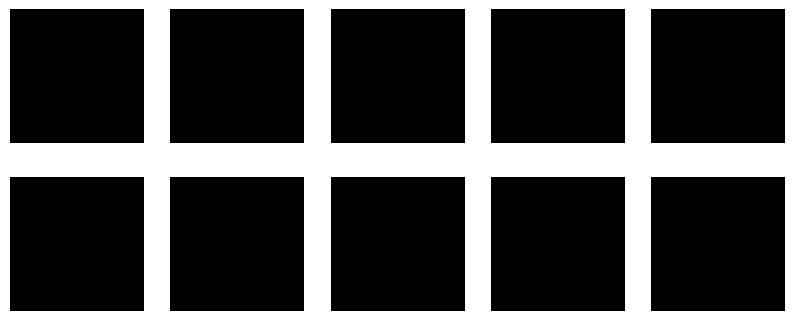

In [11]:
gamma = torch.rand(10, 1, 1, 1).to(device)
samples, target, y = path.sample_conditional_path(torch.ones_like(gamma))

# plot the samples
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(10):
    img = samples[i].detach().cpu().view(1, 32, 32).squeeze().numpy()
    axes[i//5, i%5].imshow(img, cmap="gray")
    axes[i//5, i%5].axis("off")
plt.show()

# plot the target
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(10):
    img = target[i].detach().cpu().view(1, 32, 32).squeeze().numpy()
    axes[i//5, i%5].imshow(img, cmap="gray")
    axes[i//5, i%5].axis("off")
plt.show()

Step 33, norm_grad: 48.347:  34%|███▍      | 34/100 [00:05<00:10,  6.50it/s] 


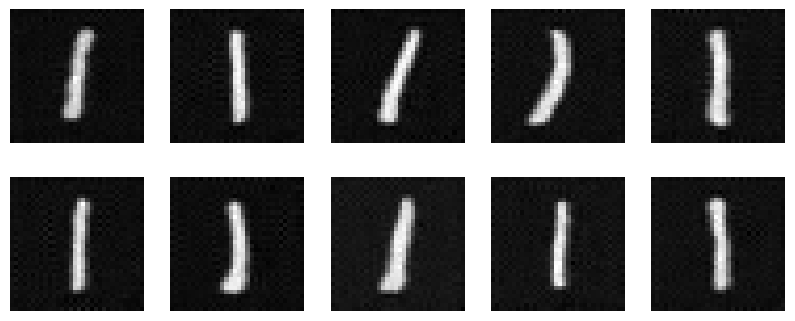

In [12]:
from matplotlib import pyplot as plt
from tqdm import tqdm

def cfe_grad(model, x, t, y, guidance_scale = 5.0):
    guided_grad = model(x, t, y)
    unguided_grad = model(x, t, torch.ones_like(y) * 10)
    return (1 - guidance_scale) * unguided_grad + guidance_scale * guided_grad

def sample_EqM(model, st, step_size, nag_factor, g_threshold, max_steps = 50, target_y = 1, guidance_scale = 5.0):
    model = model.eval()
    x = st
    x_last = st
    y = torch.ones(st.shape[0]).to(st.device).int() * target_y
    t = torch.zeros(st.shape[0], 1, 1, 1).to(st.device)
    grad = cfe_grad(model, st, t, y, guidance_scale)
    
    step = 0
    norm_grad = torch.norm(grad)
    pbar = tqdm(range(max_steps))
    
    while norm_grad > g_threshold and step < max_steps:
        
        x_last = x
        x = x - step_size*grad
        new_input = x + nag_factor*(x-x_last)
        grad = cfe_grad(model, new_input, t, y)
        norm_grad = torch.norm(grad)
        
        pbar.set_description(f'Step {step}, norm_grad: {norm_grad.item():.3f}')
        step += 1
        pbar.update(1)
    return x_last

unet.eval()
result = sample_EqM(unet, 
                    path.p_simple.sample(10)[0], 
                    step_size=0.01, 
                    nag_factor=0.4,
                    g_threshold=55,
                    max_steps=100,
                    guidance_scale=1.0,
                    target_y=1)
# plot out the first 10 images as a grid
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(10):
    img = result[i].detach().cpu().view(1, 32, 32).squeeze().numpy()
    axes[i//5, i%5].imshow(img, cmap="gray")
    axes[i//5, i%5].axis("off")
plt.show()